In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

from pycaret.classification import setup, compare_models

sns.set_palette('pastel')

In [1]:
# Cargar los datos
df = pd.read_csv('data/train_data.csv', sep=';')
df.head()

,id_colaborador,id_ultimo_jefe,seniority,modalidad_trabajo,distancia_oficina,dias_baja_salud,genero,canal_reclutamiento,permanencia_promedio,fecha_nacimiento,salario,performance_score,psi_score,fecha_incorporacion,estado_civil,abandono_6meses
0,100247,102074.0,1,Híbrida,1.760,1,Mujer,Ferias & Networking,1,25/11/1999,140011,99.0,75,25/01/2018,Soltero,0
1,103355,102115.0,1,Híbrida,0.760,2,Hombre,Ferias & Networking,2,16/10/1996,182774,99.0,81,24/07/2021,Soltero,1
2,100669,102060.0,1,Híbrida,4.950,3,Mujer,Referidos,11,29/01/1971,682106,96.0,74,13/07/2016,Viudo,0
3,103760,102062.0,1,Híbrida,13.030,2,Hombre,Linkedin,2,28/04/1992,270232,96.0,82,21/07/2014,Soltero,1
4,100965,102062.0,1,Híbrida,13.045,2,Hombre,Linkedin,2,3/05/1992,266804,95.0,82,22/07/2014,Soltero,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_colaborador        2152 non-null   int64  
 1   id_ultimo_jefe        2061 non-null   float64
 2   seniority             2152 non-null   int64  
 3   modalidad_trabajo     2152 non-null   object 
 4   distancia_oficina     2152 non-null   float64
 5   dias_baja_salud       2152 non-null   int64  
 6   genero                2152 non-null   object 
 7   canal_reclutamiento   2152 non-null   object 
 8   permanencia_promedio  2152 non-null   int64  
 9   fecha_nacimiento      2152 non-null   object 
 10  salario               2152 non-null   int64  
 11  performance_score     2084 non-null   float64
 12  psi_score             2152 non-null   int64  
 13  fecha_incorporacion   2152 non-null   object 
 14  estado_civil          2152 non-null   object 
 15  abandono_6meses      

## Preprocesamiento
- Poner los tipos de datos correctos a las columnas
- Hace imputacion a las variables con valores faltantes
- Hacen encoding a las variables binarias (solo dos valores unicos)
- Hacer encoding usando dummies a las variables categoricas

In [3]:
def check_swek_columns(df):
    skew_df = pd.DataFrame(df.select_dtypes('number').columns, columns=['Feature'])
    skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: skew(df[feature]))
    skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
    skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x > 0.5 else False)

    return skew_df.query('Skewed == True')['Feature'].values


In [4]:
def preprocess_data(df):
    X = df.copy()

    # Drop variables que no se van a usar (para este experimento)
    X = X.drop(['id_colaborador', 'id_ultimo_jefe', 'abandono_6meses'], axis=1)

    # Cambio de variables a tipo correcto
    X['seniority'] = X['seniority'].map({1: 'No', 2: 'Si'})

    # Imputacion de valores faltantes
    X['performance_score'] = X['performance_score'].fillna(0.0)

    # Extraccion de fechas
    for col in ['fecha_nacimiento', 'fecha_incorporacion']:
        X[col] = pd.to_datetime(X[col], dayfirst=True)
        X[f'year_{col}'] = X[col].dt.year
        X[f'month_{col}'] = X[col].dt.month
        X[f'day_{col}'] = X[col].dt.day
        X.drop(col, axis=1, inplace=True)

    # Transformacion de variables (Aplicando transformacion log(x + 1))
    for col in check_swek_columns(X):
        X[col] = np.log1p(X[col])

    # Codificar los datos categoricos
    X = pd.get_dummies(X, dtype=int)

    # Escalar los datos
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)

    return X

In [5]:
df_train = preprocess_data(df)

In [6]:
df_train

,distancia_oficina,dias_baja_salud,permanencia_promedio,salario,performance_score,psi_score,year_fecha_nacimiento,month_fecha_nacimiento,day_fecha_nacimiento,year_fecha_incorporacion,...,genero_Mujer,canal_reclutamiento_Ferias & Networking,canal_reclutamiento_Headhunter,canal_reclutamiento_Linkedin,canal_reclutamiento_Portal Web,canal_reclutamiento_Referidos,estado_civil_Casado,estado_civil_Divorciado,estado_civil_Soltero,estado_civil_Viudo
0,-0.802166,-0.630552,-1.987195,-1.535942,1.483346,-0.047317,1.586773,1.227265,1.052913,0.127865,...,1.017817,2.446837,-0.122859,-0.541543,-0.919579,-0.431658,-0.794694,-0.339155,1.151732,-0.294735
1,-1.940085,0.009033,-1.302596,-1.119748,1.483346,0.944488,1.305478,0.938938,0.030409,0.994076,...,-0.982495,2.446837,-0.122859,-0.541543,-0.919579,-0.431658,-0.794694,-0.339155,1.151732,-0.294735
2,1.140647,0.462826,1.038064,0.936692,1.364784,-0.212617,-1.038648,-1.656004,1.507359,-0.449608,...,1.017817,-0.408691,-0.122859,-0.541543,-0.919579,2.316649,-0.794694,-0.339155,-0.868258,3.392879
3,3.310191,0.009033,-1.302596,-0.509141,1.364784,1.109788,0.930418,-0.791023,1.393747,-1.027082,...,-0.982495,-0.408691,-0.122859,1.846574,-0.919579,-0.431658,-0.794694,-0.339155,1.151732,-0.294735
4,3.312893,0.009033,-1.302596,-0.529077,1.325264,1.109788,0.930418,-0.502696,-1.446540,-1.027082,...,-0.982495,-0.408691,-0.122859,1.846574,-0.919579,-0.431658,-0.794694,-0.339155,1.151732,-0.294735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,-0.620960,1.741997,-0.816865,-0.447243,-2.429197,-1.700324,-0.569823,1.515592,0.484855,1.571549,...,1.017817,-0.408691,-0.122859,-0.541543,1.087454,-0.431658,1.258345,-0.339155,-0.868258,-0.294735
2148,-1.876232,2.322050,1.298336,0.322654,-2.429197,1.109788,-0.569823,0.938938,0.825690,1.571549,...,1.017817,-0.408691,-0.122859,1.846574,-0.919579,-0.431658,1.258345,-0.339155,-0.868258,-0.294735
2149,-0.929004,-0.630552,1.038064,0.822189,-2.429197,-1.535023,-0.944883,-1.079350,0.371244,1.571549,...,-0.982495,-0.408691,-0.122859,-0.541543,1.087454,-0.431658,-0.794694,-0.339155,1.151732,-0.294735
2150,1.427654,0.009033,0.128007,1.173842,-2.429197,0.779187,-1.038648,-0.791023,-0.992094,1.571549,...,-0.982495,-0.408691,-0.122859,-0.541543,1.087454,-0.431658,1.258345,-0.339155,-0.868258,-0.294735


In [7]:
df_train.isna().sum()

distancia_oficina                          0
dias_baja_salud                            0
permanencia_promedio                       0
salario                                    0
performance_score                          0
psi_score                                  0
year_fecha_nacimiento                      0
month_fecha_nacimiento                     0
day_fecha_nacimiento                       0
year_fecha_incorporacion                   0
month_fecha_incorporacion                  0
day_fecha_incorporacion                    0
seniority_No                               0
seniority_Si                               0
modalidad_trabajo_Híbrida                  0
modalidad_trabajo_Presencial               0
genero_Hombre                              0
genero_Mujer                               0
canal_reclutamiento_Ferias & Networking    0
canal_reclutamiento_Headhunter             0
canal_reclutamiento_Linkedin               0
canal_reclutamiento_Portal Web             0
canal_recl

In [9]:
df_analysis = pd.concat([df_train, df.abandono_6meses], axis=1)
df_analysis.corr()['abandono_6meses'].sort_values() * 100

performance_score                          -31.070841
seniority_No                               -13.232414
canal_reclutamiento_Referidos              -10.633166
estado_civil_Casado                         -7.122491
modalidad_trabajo_Presencial                -6.185137
canal_reclutamiento_Ferias & Networking     -5.998766
estado_civil_Viudo                          -4.865917
genero_Hombre                               -4.351872
day_fecha_nacimiento                        -3.889693
canal_reclutamiento_Headhunter              -3.782405
permanencia_promedio                        -2.252765
psi_score                                   -0.940881
distancia_oficina                           -0.833624
month_fecha_nacimiento                       0.813130
estado_civil_Divorciado                      2.000020
salario                                      2.089465
year_fecha_nacimiento                        2.416192
month_fecha_incorporacion                    2.943008
day_fecha_incorporacion     

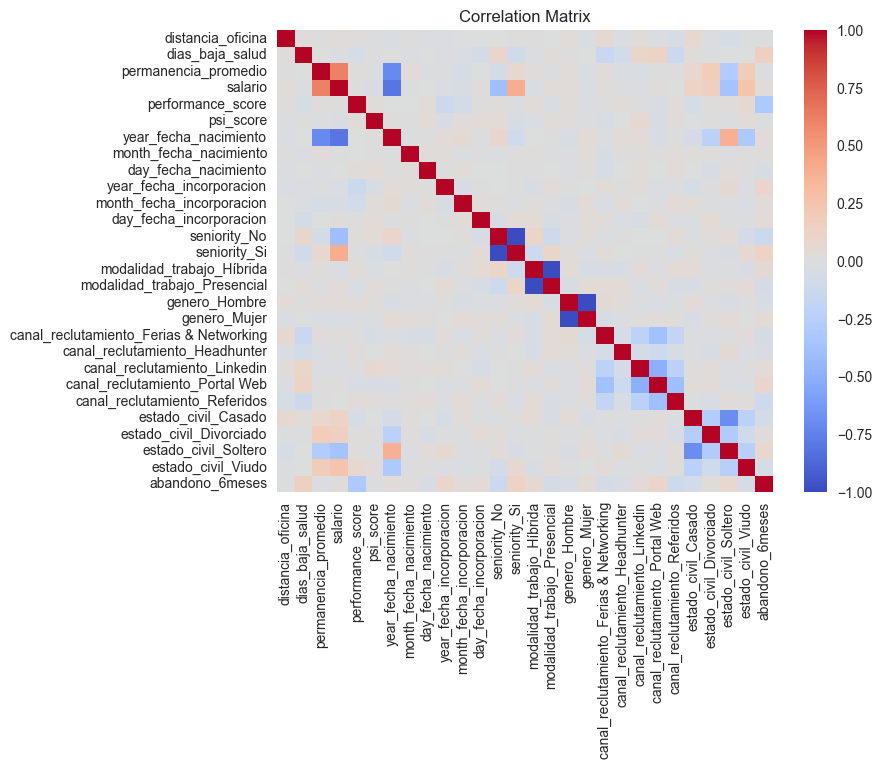

In [11]:
corr_matrix = df_analysis.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Model Selection

In [9]:
# _ = setup(data=pd.concat([df_train, df.abandono_6meses], axis=1), target='abandono_6meses', preprocess=False)

In [10]:
# compare_models(sort='F1')

## Modelo Individual
Se selecciono el mejor de la tabla anterior

In [63]:
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, KFold

In [64]:
# Split data in X and y
X = df_train
y = df.abandono_6meses

In [65]:
# Entrenar solo el mejor modelo
model = XGBClassifier()
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [66]:
# Validate
kf = KFold(n_splits=10)

scores = cross_val_score(model, X, y, cv=kf, scoring='f1')

In [68]:
scores.mean()

0.5486964569665075

## Bagging Ensemble

In [69]:
models = {
    'xgb': XGBClassifier(),
    'catboost': CatBoostClassifier(verbose=0),
    'lgbm': LGBMClassifier(verbose=0),
    'rf': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
}

for name, model in models.items():
    model.fit(X, y)
    print(f'{name} trained.')

xgb trained.
catboost trained.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
lgbm trained.
rf trained.
gbc trained.


In [70]:
results = {}
kf = KFold(n_splits=10)

for name, model in models.items():
    result = cross_val_score(model, X, y, cv=kf, scoring='f1')
    results[name] = result

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


In [71]:
results

{'xgb': array([0.42028986, 0.51515152, 0.72852234, 0.38709677, 0.34545455,
        0.41904762, 0.54794521, 0.62903226, 0.71942446, 0.775     ]),
 'catboost': array([0.37931034, 0.5388601 , 0.75510204, 0.2972973 , 0.35955056,
        0.26506024, 0.5320197 , 0.66409266, 0.7440273 , 0.8048048 ]),
 'lgbm': array([0.38983051, 0.58415842, 0.73037543, 0.37362637, 0.43809524,
        0.32608696, 0.5625    , 0.616     , 0.72535211, 0.77945619]),
 'rf': array([0.1980198 , 0.52173913, 0.74048443, 0.3       , 0.42105263,
        0.24096386, 0.5645933 , 0.62650602, 0.70945946, 0.7515528 ]),
 'gbc': array([0.4137931 , 0.54255319, 0.76666667, 0.19178082, 0.31460674,
        0.20253165, 0.58515284, 0.68382353, 0.70860927, 0.7761194 ])}

In [72]:
for name, result in results.items():
    print('----\n' + name)
    print(np.mean(result))
    print(np.std(result))

----
xgb
0.5486964569665075
0.14865973526580706
----
catboost
0.5340125066414994
0.19131197670527178
----
lgbm
0.5525481225210201
0.1552319456743133
----
rf
0.5074371428503666
0.19738410098588
----
gbc
0.5185637213012733
0.21344001250186315


## Make submission

In [73]:
df_test = pd.read_csv('data/test_data.csv', sep=';')
df_test.head()

,id_colaborador,id_ultimo_jefe,seniority,modalidad_trabajo,distancia_oficina,dias_baja_salud,genero,canal_reclutamiento,permanencia_promedio,fecha_nacimiento,salario,performance_score,psi_score,fecha_incorporacion,estado_civil
0,100486,102115.0,1,Híbrida,0.795,2,Hombre,Ferias & Networking,2,19/01/1997,181654,99,81,24/07/2021,Soltero
1,103752,102074.0,1,Híbrida,1.715,1,Mujer,Ferias & Networking,1,20/08/1999,140986,97,75,27/01/2018,Soltero
2,103937,102150.0,1,Híbrida,2.375,1,Hombre,Portal Web,6,29/10/1984,406690,96,69,24/04/2022,Soltero
3,101744,102172.0,1,Híbrida,2.185,3,Hombre,Linkedin,3,9/11/1992,249107,95,73,23/05/2023,Casado
4,101037,102060.0,1,Híbrida,4.660,3,Hombre,Referidos,10,14/07/1969,698318,95,81,20/06/2015,Viudo


In [77]:
X_test = preprocess_data(df_test)
X_test

,distancia_oficina,dias_baja_salud,permanencia_promedio,salario,performance_score,psi_score,year_fecha_nacimiento,month_fecha_nacimiento,day_fecha_nacimiento,year_fecha_incorporacion,...,genero_Mujer,canal_reclutamiento_Ferias & Networking,canal_reclutamiento_Headhunter,canal_reclutamiento_Linkedin,canal_reclutamiento_Portal Web,canal_reclutamiento_Referidos,estado_civil_Casado,estado_civil_Divorciado,estado_civil_Soltero,estado_civil_Viudo
0,-1.953543,0.036068,-1.299468,-1.162980,2.031478,0.924600,1.432884,-1.610742,0.383090,0.978219,...,-1.027100,2.472383,-0.116393,-0.581161,-0.868905,-0.441889,-0.791460,-0.376680,1.234909,-0.323154
1,-0.864076,-0.590283,-1.976470,-1.561172,1.619161,-0.074077,1.620913,0.428099,0.499213,0.118589,...,0.973615,2.472383,-0.116393,-0.581161,-0.868905,-0.441889,-0.791460,-0.376680,1.234909,-0.323154
2,-0.291143,-0.590283,0.115258,0.103270,1.413002,-1.072753,0.210695,1.010625,1.544319,1.264763,...,-1.027100,-0.404468,-0.116393,-0.581161,1.150874,-0.441889,-0.791460,-0.376680,1.234909,-0.323154
3,-0.443703,0.480470,-0.819128,-0.666850,1.206844,-0.406969,0.962811,1.301888,-0.778138,1.551306,...,-1.027100,-0.404468,-0.116393,1.720693,-0.868905,-0.441889,1.263488,-0.376680,-0.809776,-0.323154
4,1.070151,0.480470,0.869934,0.952663,1.206844,0.924600,-1.199523,0.136836,-0.197524,-0.741041,...,-1.027100,-0.404468,-0.116393,-0.581161,-0.868905,2.263010,-0.791460,-0.376680,-0.809776,3.094498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015,0.152894,0.036068,1.596781,0.958269,0.176051,-1.072753,-1.105508,-1.319479,0.847582,1.551306,...,0.973615,-0.404468,-0.116393,-0.581161,1.150874,-0.441889,-0.791460,-0.376680,1.234909,-0.323154
2016,0.003757,-1.661036,-0.142126,0.904117,0.794527,-1.572091,-1.105508,0.719362,1.660442,1.551306,...,0.973615,-0.404468,-0.116393,-0.581161,1.150874,-0.441889,-0.791460,2.654771,-0.809776,-0.323154
2017,0.738435,-0.590283,0.338214,1.309337,-1.060900,-1.072753,-1.105508,-0.154427,-0.197524,1.551306,...,-1.027100,-0.404468,-0.116393,-0.581161,1.150874,-0.441889,-0.791460,-0.376680,1.234909,-0.323154
2018,2.013896,-0.590283,0.534876,0.998742,0.382210,-0.074077,-1.293537,-0.445690,1.660442,1.551306,...,0.973615,-0.404468,-0.116393,1.720693,-0.868905,-0.441889,-0.791460,-0.376680,1.234909,-0.323154


### Combine Predictions

In [78]:
from sklearn.ensemble import VotingClassifier

final_model = VotingClassifier(estimators=[
    ('xgb', XGBClassifier()),
    ('catboost', CatBoostClassifier(verbose=0)),
    ('lgbm', LGBMClassifier(verbose=0)),
    ('rf', RandomForestClassifier()),
    ('gbc', GradientBoostingClassifier())
])

final_model.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('catboost',
                              <catboost.core.CatBoostClassifier object at 0x2b63e3d30>),
                             ('lgbm', LGBMClassifier(verbose=0)),
                             ('rf', RandomForestClassifier()),
                             ('gbc', GradientBoostingClassifier())])

In [79]:
preds = final_model.predict(X_test)

## Make a submission

In [ ]:
submission_df = pd.DataFrame({
    'ID': df_test.id_colaborador,
    'abandono_6meses': preds
})